In [115]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from adjustText import adjust_text
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np

def scatter_with_labels(ax, data, marker, size, color, labelsize, title, xlabel, ylabel, exclude_labels=None):
    texts = []

    exclude_labels = set(exclude_labels) if exclude_labels else set()
    for _, row in data.iterrows():
        color = cmap(norm(row["gini"]))
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker=marker, s=size, alpha=0.7)
        if row["metric"] not in exclude_labels:
            metric_name = row["metric"]
            if '_wi' in metric_name:
                metric_name = metric_name.replace('_wi', '')
            text_obj = ax.text(row["rank_corr"], row["val_diff"], metric_name,
                               fontsize=labelsize, clip_on=False)  # <-- allow labels outside axes
            texts.append(text_obj)

    # Label placement strategy
    if "Zoom" in title:
        adjust_text(
            texts,
            ax=ax,
            arrowprops=dict(arrowstyle='->', color='black', lw=2)
        )
    else:
        adjust_text(
            texts,
            ax=ax,
            arrowprops=dict(arrowstyle='-', color='black', lw=2),
            force_text=0.7,
            force_points=0.3,
            expand_text=(1.05, 1.2),
            expand_points=(1.05, 1.2),
            only_move={'points': 'y', 'text': 'y'}
        )

    ax.set_title(title, fontsize=45)
    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=20)

    
def scatter_without_labels(ax, data, this_metric, marker, size, color, labelsize, title, xlabel, ylabel, exclude_labels=None):
    texts = []

    exclude_labels = set(exclude_labels) if exclude_labels else set()
    for _, row in data.iterrows():
        # color = cmap(norm(row["gini"]))
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker=marker, s=size, alpha=0.7)


    ax.set_title(this_metric, fontsize=15)
#     ax.set_xlabel(xlabel, fontsize=30)
#     ax.set_ylabel(ylabel, fontsize=30)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=20)    
    
def split_metric_resolution(col_name):
    """
    Splits column names like '3rd_w_Peak_5m' into ('3rd_w_Peak', '5m').
    Assumes resolution is always the last underscore-suffix (e.g., '_5m').
    """
    parts = col_name.rsplit('_', 1)  # Split only on the last underscore
    if len(parts) == 2 and parts[1] in ['5m', '30m']:
        return parts[0], parts[1]
    else:
        return col_name, None  # No valid resolution suffix found
    
def compute_metric_sensitivity(df, continuous_metrics, categorical_metrics, resolutions=["10m", "30m", "60m"]):
    rows = []

    for res in resolutions:
        for metric in continuous_metrics + categorical_metrics:
            ref_col = f"{metric}_5m"
            comp_col = f"{metric}_{res}"
            if ref_col not in df.columns or comp_col not in df.columns:
                continue

            x_vals = df[ref_col]
            y_vals = df[comp_col]
            valid = x_vals.notna() & y_vals.notna()
            x = x_vals[valid]
            y = y_vals[valid]

            if len(x) < 2:
                continue

            is_continuous = metric in continuous_metrics
            if is_continuous:
                rank_corr, _ = spearmanr(x, y)
                val_diff = np.mean(np.abs(y - x))  # MAD
            else:
                rank_corr, _ = kendalltau(x, y)
                observed_diff = np.mean(x != y) * 100  # raw % different
                observed_diff = observed_diff*100
                # Option A: Normalize based on number of classes in 5-min data
                n_classes = x.nunique()
                if n_classes > 1:
                    max_diff = (1 - 1 / n_classes) * 100  # convert to percent
                    val_diff = observed_diff / max_diff  # normalized disagreement
                else:
                    val_diff = 0  # No disagreement possible if only one class

            spread = gini(y)

            rows.append({
                "metric": metric,
                "resolution": res,
                "type": "continuous" if is_continuous else "categorical",
                "rank_corr": rank_corr,
                "val_diff": val_diff,
                "gini": spread
            })

    return pd.DataFrame(rows)

def gini(array):
    array = np.sort(np.array(array))
    n = len(array)
    if n == 0:
        return np.nan
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)) if np.sum(array) != 0 else 0

In [5]:
transformed_minmax_scaled = pd.read_csv("../../test.csv")

column_names = transformed_minmax_scaled.columns.str.replace('_log', '')
column_names = column_names.str.replace('_yj', '')
# column_names = column_names.str.replace('_wi', '')
transformed_minmax_scaled.columns = column_names

# for col in ['m2', 'm3', 'm4', 'm5']:
# #     cols_to_drop = transformed_minmax_scaled.columns[transformed_minmax_scaled.columns.str.contains(col)]
#     cols_to_drop = transformed_minmax_scaled.columns[transformed_minmax_scaled.columns.str.endswith(col)]
#     transformed_minmax_scaled.drop(cols_to_drop, axis=1, inplace=True)


metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = list(metrics)
categorical_metrics = ['3rd_ARR',  '3rd_rcg',  '3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_w_most', 
                       '4th_w_most', '5th_w_most']
continuous_metrics = [metric for metric in metrics if metric not in categorical_metrics]
continuous_metrics.remove('T50')

continuous_metrics.remove('BSC_Index')

In [159]:
summary_df = compute_metric_sensitivity(df=transformed_minmax_scaled,
    continuous_metrics=continuous_metrics,
    categorical_metrics=categorical_metrics,
    resolutions=["10m", "30m", "60m"])
summary_df = summary_df[~summary_df['metric'].isin(['m3', 'm4', 'm5'])]

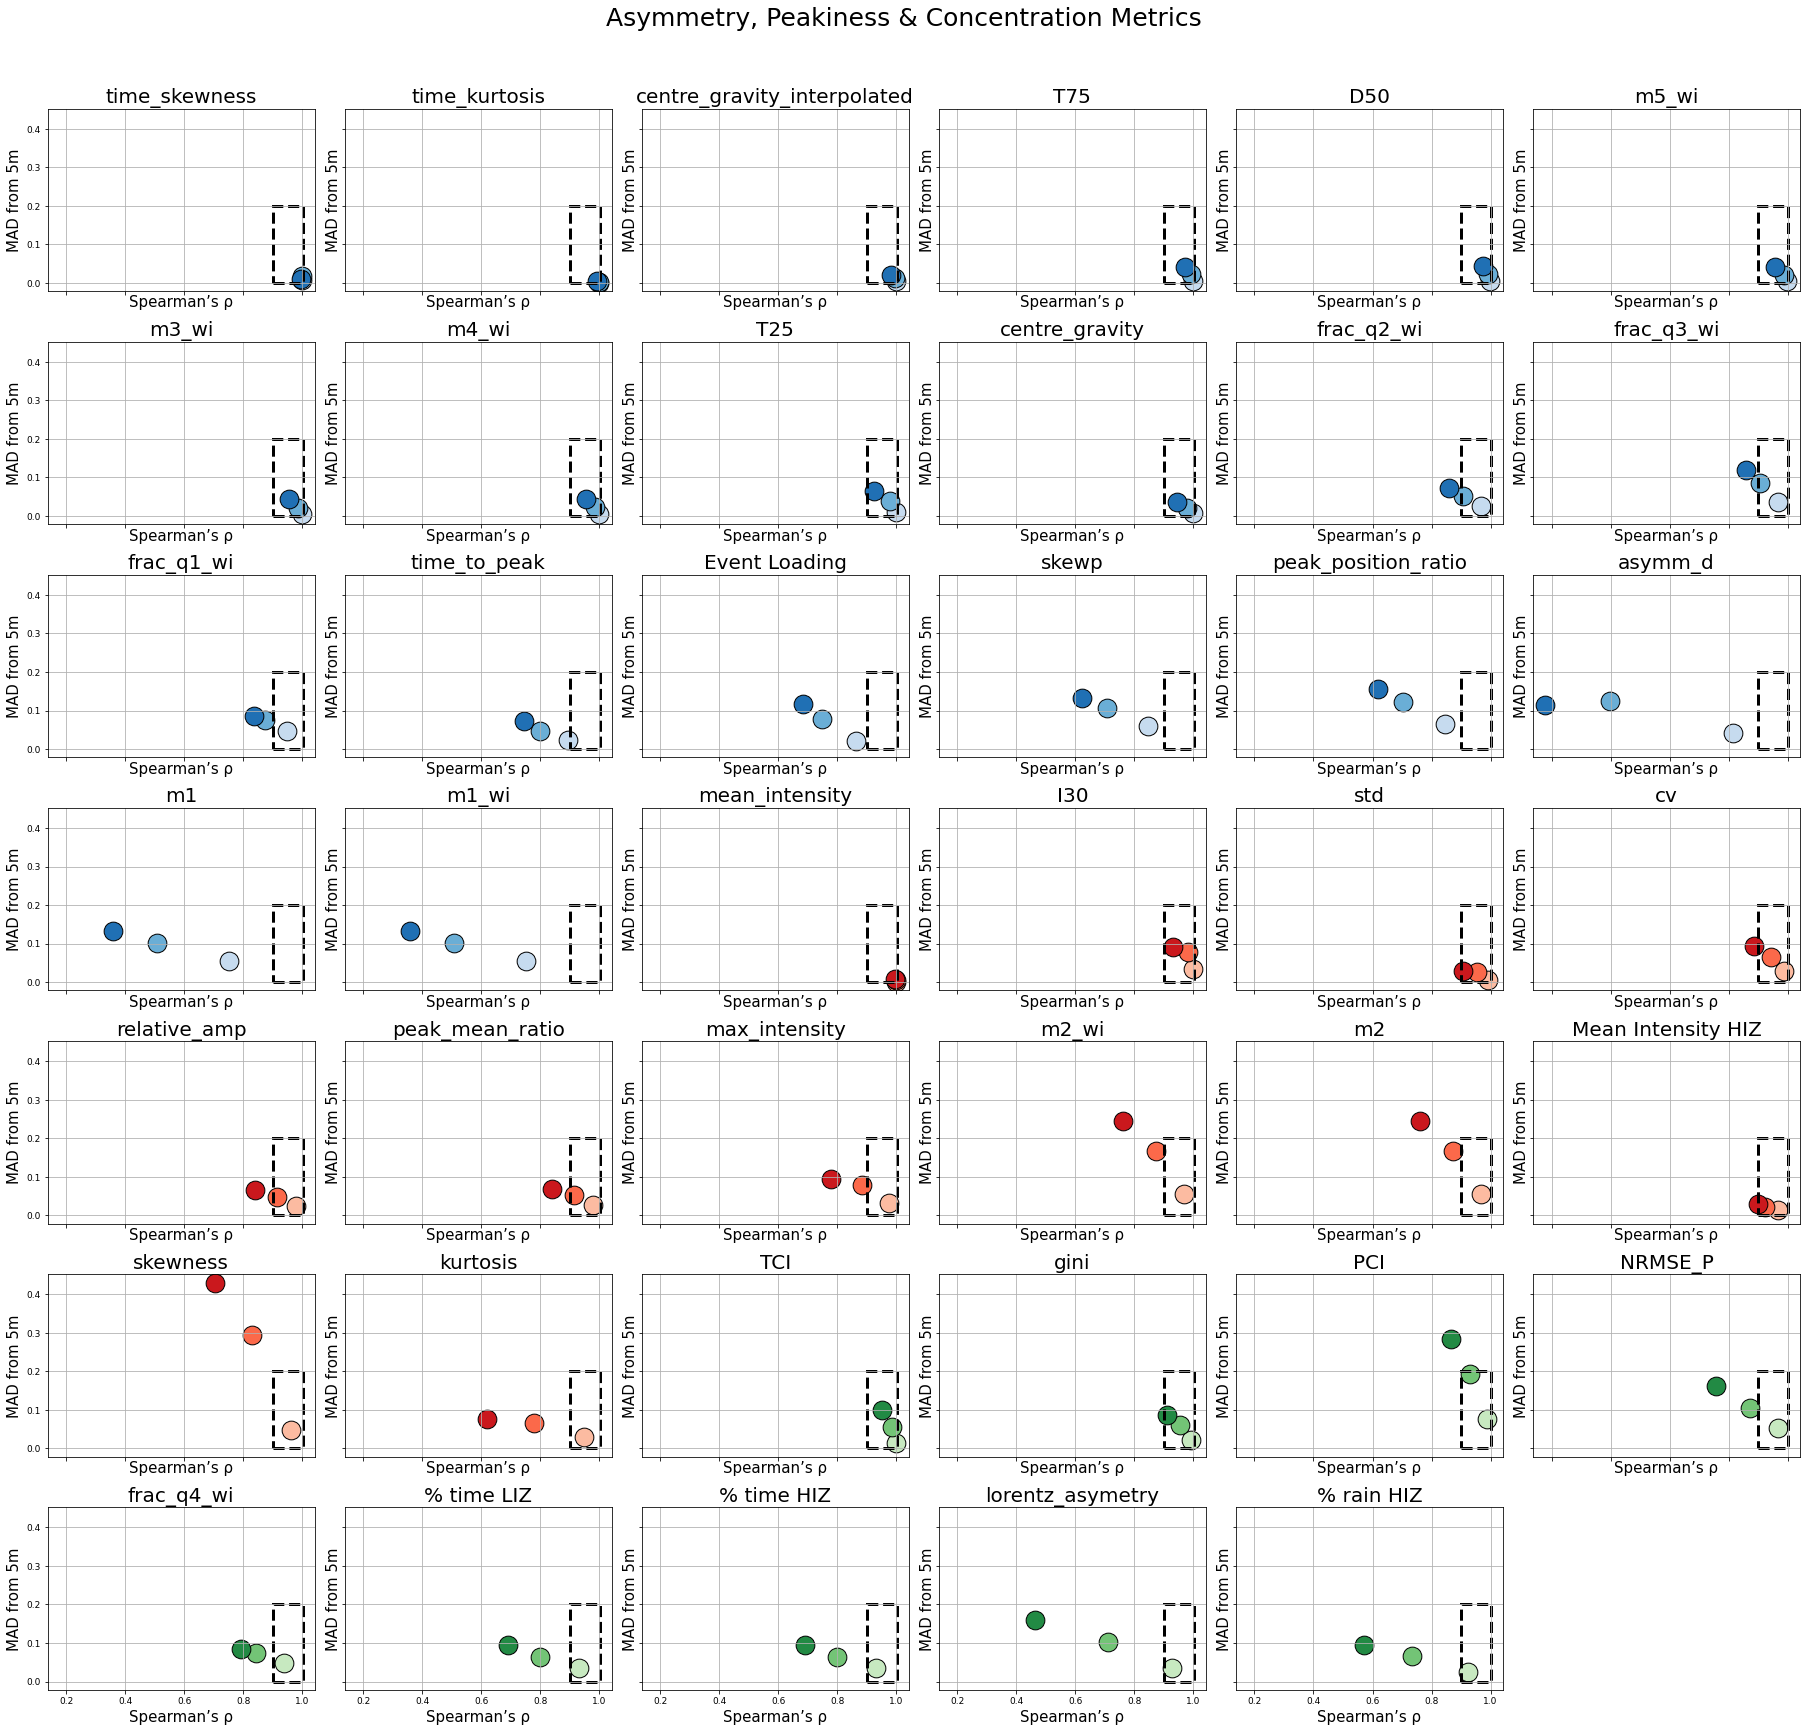

In [201]:
import matplotlib.patches as patches

# Define a function to plot given filtered_df and return axis limits
def plot_metrics_group(filtered_df_group, group_name):
    unique_metrics = filtered_df_group["metric"].unique()
    n_cols = 6
    n_rows = -(-len(unique_metrics) // n_cols)
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(4.2 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, this_metric in enumerate(unique_metrics):
        ax = axs[i]
        metric_data = filtered_df_group[filtered_df_group["metric"] == this_metric]
        scatter_without_labels(ax, metric_data, this_metric)

    # Hide unused axes
    for ax in axs[len(unique_metrics):]:
        ax.axis('off')

    fig.suptitle(f"{group_name} Metrics", fontsize=25)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Return limits from the first subplot (assuming all should be the same)
    return axs[0].get_xlim(), axs[0].get_ylim()

# Prepare the non-intermittency group
non_intermit_types = ['Asymmetry', 'Peakiness', 'Concentration']
non_intermit_df = filtered_df[filtered_df["type_2"].isin(non_intermit_types)]

# Plot and get limits
x_limits, y_limits = plot_metrics_group(non_intermit_df, "Asymmetry, Peakiness & Concentration")


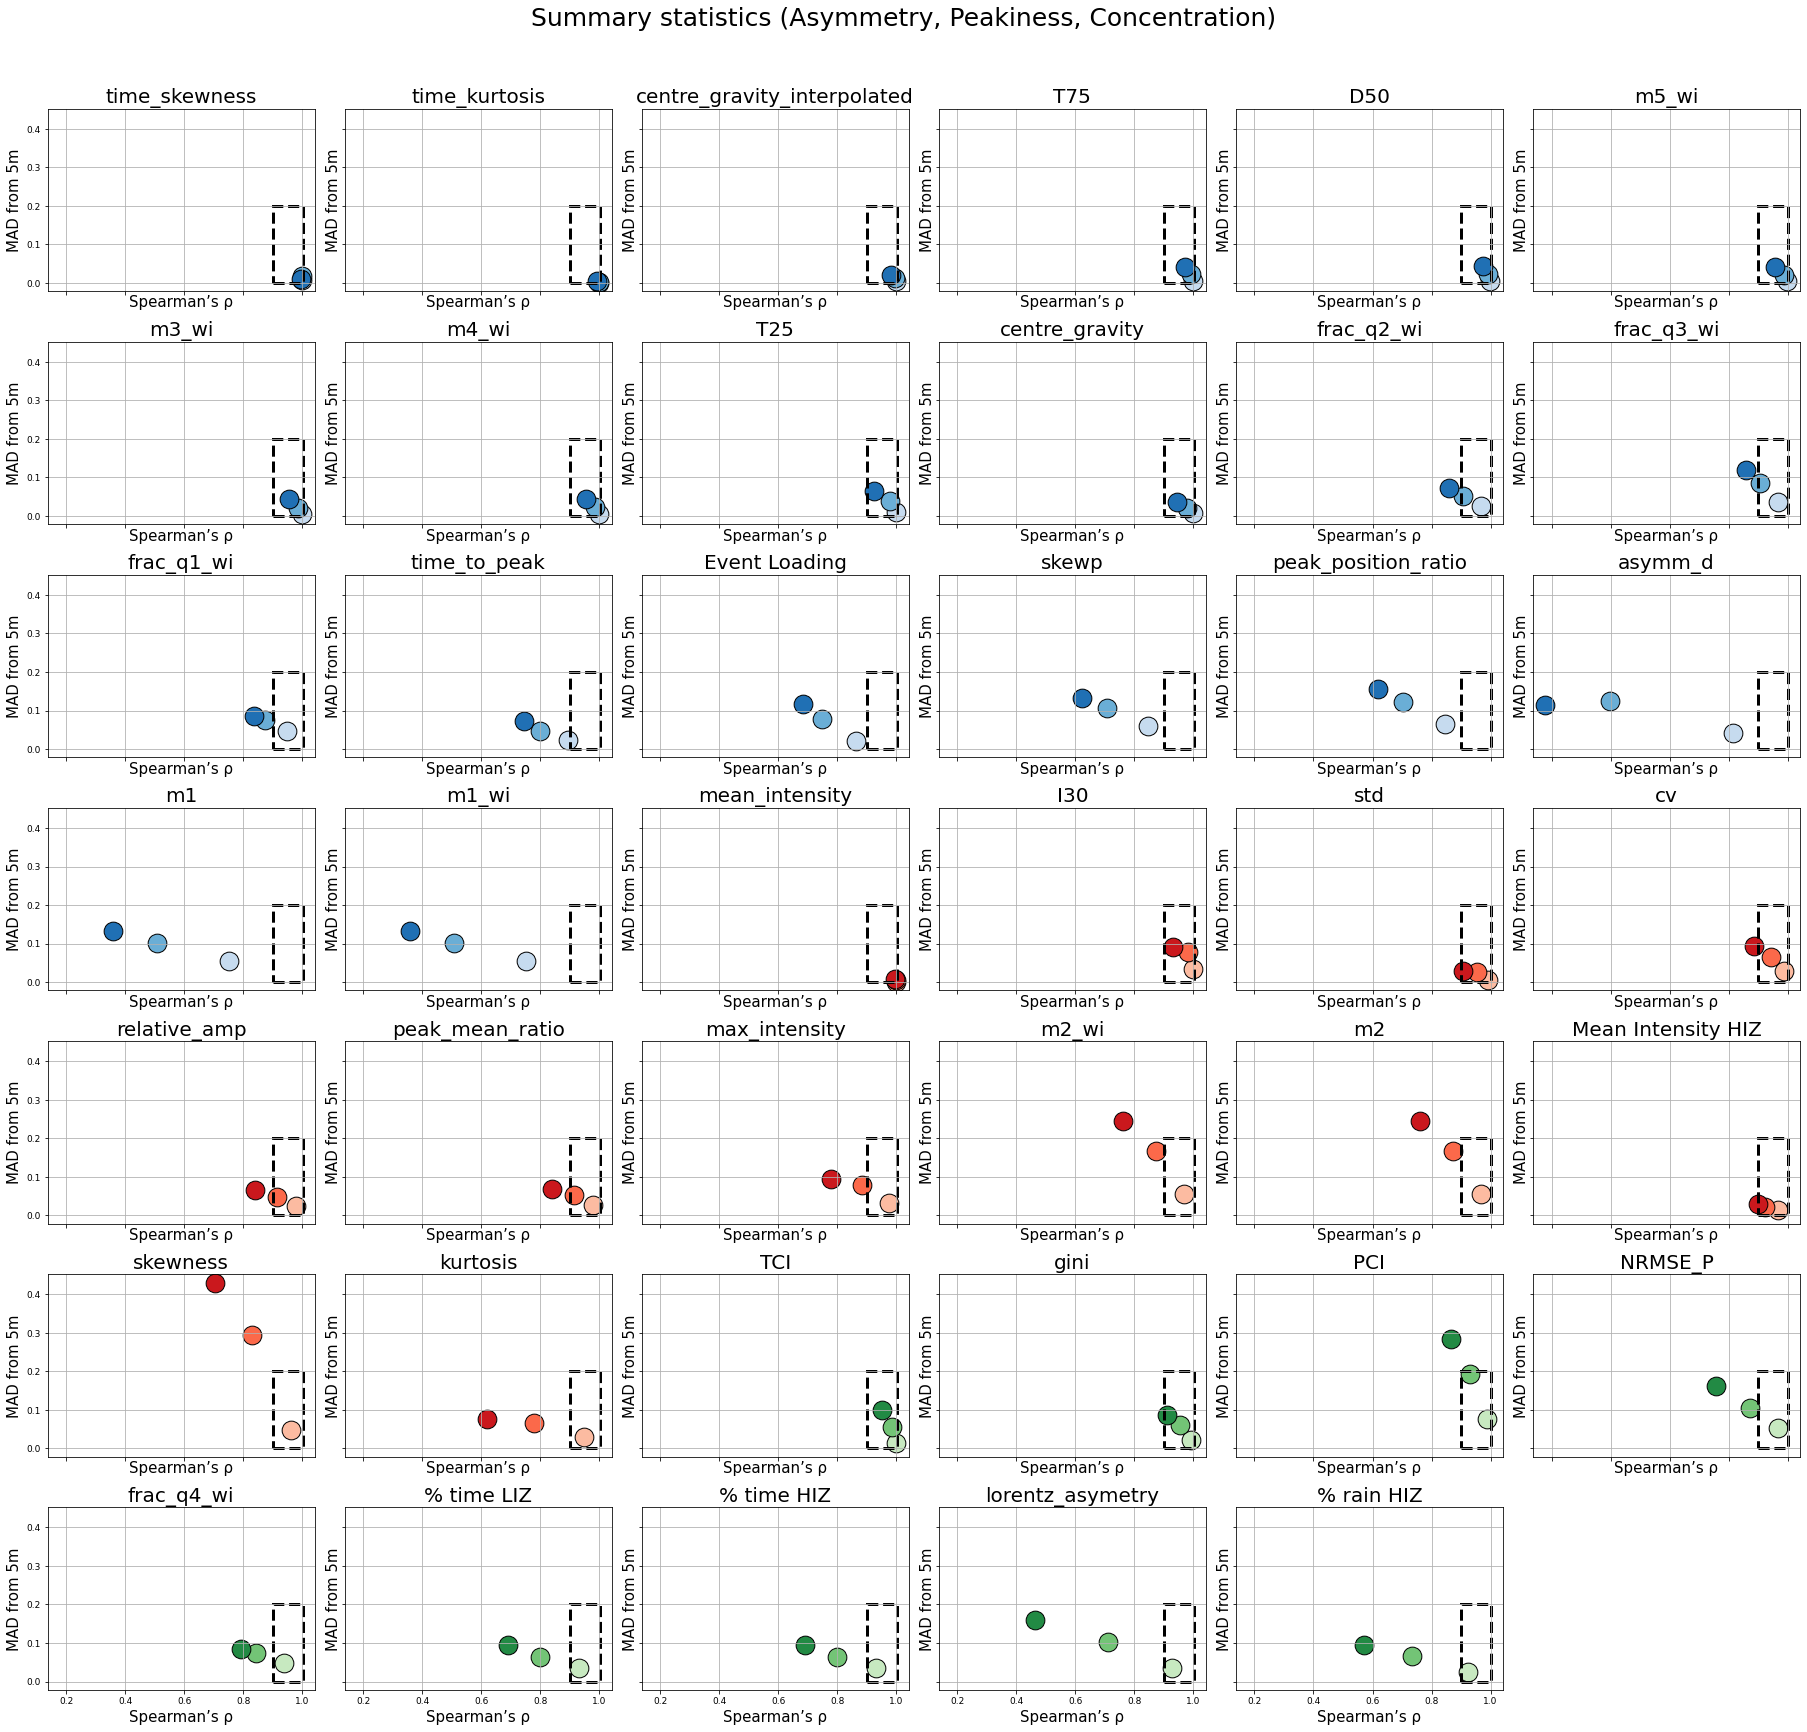

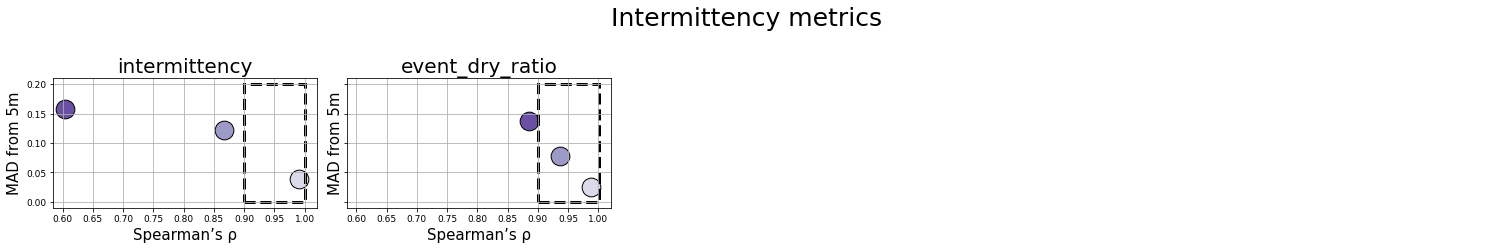

In [200]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Define color palettes by type
type_color_map = {
    'Asymmetry': sns.color_palette("Blues", 3),
    'Peakiness': sns.color_palette("Reds", 3),
    'Concentration': sns.color_palette("Greens", 3),
    'Intermittency': sns.color_palette("Purples", 3),
    'categorical': sns.color_palette("Oranges", 3),
}

resolution_index = {'10m': 0, '30m': 1, '60m': 2}

# Map type_2 to metrics
type_2_mapping = dict(zip(metric_list, type_2_list))

# Filter the dataframe
filtered_df = summary_df[~summary_df["metric"].isin(['m3', 'm4', 'm5'])].copy()
filtered_df["type_2"] = filtered_df["metric"].map(type_2_mapping)

# Exclude Categorical
filtered_df = filtered_df[filtered_df["type_2"].notna()]

# Sort by type_2 and descending rank_corr
filtered_df = filtered_df.sort_values(
    by=["type_2", "rank_corr"],
    key=lambda col: (
        col.map({'Asymmetry': 0, 'Peakiness': 1, 'Concentration': 2, 'Intermittency': 3})
        if col.name == "type_2" else -col
    )
)

# Function to scatter each metric
def scatter_without_labels(ax, data, this_metric):
    for _, row in data.iterrows():
        metric_type = row["type_2"]
        resolution = row["resolution"]
        color = type_color_map[metric_type][resolution_index[resolution]]
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker='o', s=350, alpha=1)
    ax.set_title(this_metric, fontsize=20)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_xlabel("Spearman’s ρ", fontsize=15)
    ax.set_ylabel("MAD from 5m", fontsize=15)
    
    # Highlight box
    x_min, x_max = 0.9, 1.001
    y_min, y_max = 0, 0.2
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=3, edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(rect)

# Split intermittency and other types
df_intermittency = filtered_df[filtered_df["type_2"] == "Intermittency"]
df_other = filtered_df[filtered_df["type_2"] != "Intermittency"]

# --- PLOT 1: Main Figure (non-Intermittency metrics) ---
unique_metrics_main = df_other["metric"].unique()
n_cols_main = 6
n_rows_main = -(-len(unique_metrics_main) // n_cols_main)

fig_main, axs_main = plt.subplots(ncols=n_cols_main, nrows=n_rows_main,
                                  figsize=(4.2 * n_cols_main, 3.5 * n_rows_main),
                                  sharex=True, sharey=True)
axs_main = axs_main.flatten()

for i, this_metric in enumerate(unique_metrics_main):
    ax = axs_main[i]
    metric_data = df_other[df_other["metric"] == this_metric]
    scatter_without_labels(ax, metric_data, this_metric)

for ax in axs_main[len(unique_metrics_main):]:
    ax.axis('off')

fig_main.suptitle("Summary statistics (Asymmetry, Peakiness, Concentration)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
fig_main.savefig("metrics_main_types.png", dpi=300, facecolor='white')

# --- PLOT 2: Intermittency Figure ---
if not df_intermittency.empty:
    unique_metrics_int = df_intermittency["metric"].unique()
    n_cols_int = 5
    n_rows_int = -(-len(unique_metrics_int) // n_cols_int)

    fig_int, axs_int = plt.subplots(ncols=n_cols_int, nrows=n_rows_int,
                                    figsize=(4.2 * n_cols_int, 3.5 * n_rows_int),
                                    sharex=True, sharey=True)
    axs_int = axs_int.flatten()

    for i, this_metric in enumerate(unique_metrics_int):
        ax = axs_int[i]
        metric_data = df_intermittency[df_intermittency["metric"] == this_metric]
        scatter_without_labels(ax, metric_data, this_metric)

    for ax in axs_int[len(unique_metrics_int):]:
        ax.axis('off')

    fig_int.suptitle("Intermittency metrics", fontsize=25)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    fig_int.savefig("metrics_intermittency.png", dpi=300, facecolor='white')


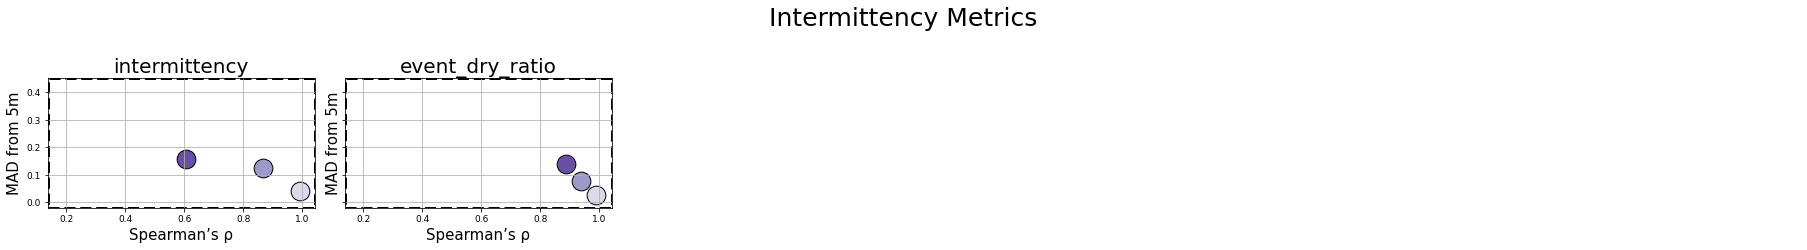

In [202]:
def scatter_with_fixed_limits(ax, data, this_metric, xlims, ylims):
    for _, row in data.iterrows():
        metric_type = row["type_2"]
        resolution = row["resolution"]
        color = type_color_map[metric_type][resolution_index[resolution]]
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker='o', s=350, alpha=1)

    ax.set_title(this_metric, fontsize=20)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_xlabel("Spearman’s ρ", fontsize=15)
    ax.set_ylabel("MAD from 5m", fontsize=15)

    # Apply fixed axis limits from previous figure
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # Highlight box with those limits
    rect = patches.Rectangle((xlims[0], ylims[0]), xlims[1] - xlims[0], ylims[1] - ylims[0],
                             linewidth=3, edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(rect)


# Plot intermittency metrics separately
intermittency_df = filtered_df[filtered_df["type_2"] == "Intermittency"]
unique_metrics_intermit = intermittency_df["metric"].unique()
n_cols = 6
n_rows = -(-len(unique_metrics_intermit) // n_cols)
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(4.2 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
axs = axs.flatten()

for i, this_metric in enumerate(unique_metrics_intermit):
    ax = axs[i]
    metric_data = intermittency_df[intermittency_df["metric"] == this_metric]
    scatter_with_fixed_limits(ax, metric_data, this_metric, x_limits, y_limits)

# Hide unused axes
for ax in axs[len(unique_metrics_intermit):]:
    ax.axis('off')

fig.suptitle("Intermittency Metrics", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


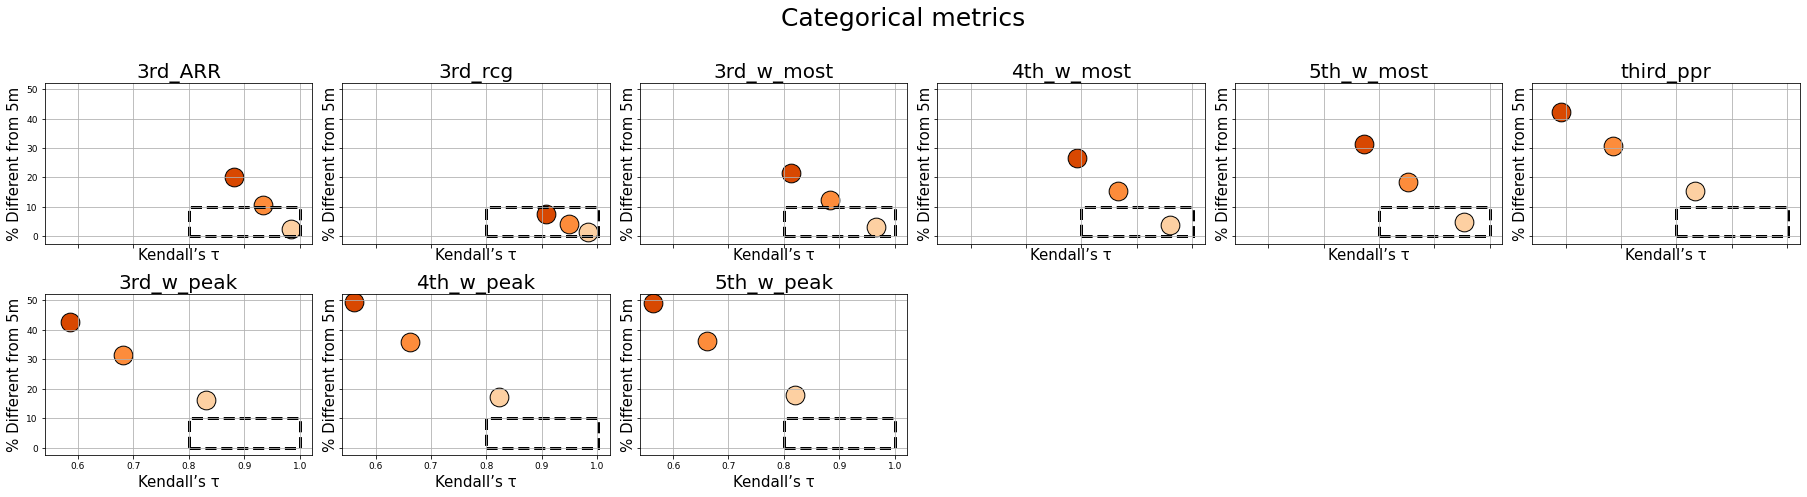

In [204]:
# Filter the dataframe
filtered_df=summary_df[summary_df['type']=='categorical']
# Sort by type_2
filtered_df = filtered_df.sort_values(
    by=["type", "rank_corr"],
    key=lambda col: (
        col.map({'categorical': 0})
        if col.name == "type" else -col))

# Unique metrics
unique_metrics = filtered_df["metric"].unique()
# Plot setup
n_cols = 6
n_rows = -(-len(unique_metrics) // n_cols)
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(4.2 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
axs = axs.flatten()

# Scatter function
def scatter_without_labels(ax, data, this_metric):
    for _, row in data.iterrows():
        metric_type = row["type"]
        resolution = row["resolution"]
        color = type_color_map[metric_type][resolution_index[resolution]]
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker='o', s=350, alpha=1)
    ax.set_title(this_metric, fontsize=20)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_xlabel("Kendall’s τ", fontsize=15)
    ax.set_ylabel("% Different from 5m", fontsize=15)
    
    x_min, x_max = 0.8, 1.001  
    y_min, y_max = 0, 10  

    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                             linewidth=3, edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(rect)
    

# Plot each metric
for i, this_metric in enumerate(unique_metrics):
    ax = axs[i]
    metric_data = filtered_df[filtered_df["metric"] == this_metric]
    scatter_without_labels(ax, metric_data, this_metric)

# Hide unused axes
for ax in axs[len(unique_metrics):]:
    ax.axis('off')

# Main title and layout
fig.suptitle("Categorical metrics", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Save
fig.savefig("categorical_metrics_single_figure.png", dpi=300, facecolor='white')

In [172]:
# First: Create the mapping for continuous metrics
metric_list = ['frac_q3_wi', 'peak_mean_ratio', 'cv', 'frac_q1_wi', 'time_kurtosis', 'Mean Intensity HIZ',
               '% rain HIZ', 'frac_q2_wi', 'event_dry_ratio', 'lorentz_asymetry', 'm5_wi', 'D50', 'm1',
               'Event Loading', 'time_to_peak', 'asymm_d', 'centre_gravity', 'max_intensity', 'm3_wi',
               'kurtosis', 'skewp', 'I30', 'peak_position_ratio', 'std', 'PCI', 'time_skewness', 'm1_wi',
               'mean_intensity', 'intermittency', 'T75', 'relative_amp', 'NRMSE_P', 'm2_wi', '% time LIZ',
               'm4_wi', 'T25', 'm2', 'skewness', '% time HIZ', 'centre_gravity_interpolated', 'frac_q4_wi',
               'gini', 'TCI']

type_2_list = ['Asymmetry', 'Peakiness', 'Peakiness', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Concentration',
               'Asymmetry', 'Intermittency', 'Concentration', 'Asymmetry', 'Asymmetry', 'Asymmetry', 'Asymmetry',
               'Asymmetry', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Asymmetry', 'Peakiness', 'Asymmetry', 'Peakiness',
               'Asymmetry', 'Peakiness', 'Concentration', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Intermittency',
               'Asymmetry', 'Peakiness', 'Concentration', 'Peakiness', 'Concentration', 'Asymmetry', 'Asymmetry',
               'Peakiness', 'Peakiness', 'Concentration', 'Asymmetry', 'Concentration', 'Concentration', 'Concentration']

In [68]:
def plot_scatter(resolution):
    cmap = plt.cm.viridis
    gini_min = summary_df['gini'].min()
    gini_max = summary_df['gini'].max()
    norm = mcolors.Normalize(vmin=gini_min, vmax=gini_max)

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(25, 10), gridspec_kw={'width_ratios':[2,6, 4]})

    ################################## 
    # First plot
    ##################################
    resolution = resolution
    subset_cont = summary_df[(summary_df["resolution"] == resolution) & (summary_df["type"] == "categorical")]

    # Plot full scatter on ax1
    # scatter_with_labels(ax1, subset_cont, 'o',350, 15, f"Continuous @ 10m", "Spearman’s ρ", "MAD from 5m")
    scatter_with_labels(ax0, subset_cont, '^', 250, 20,
                        f"Categorical @ {resolution}", "Kendall’s τ", "% Different from 5m",
                        exclude_labels=[])

    # Define the zoom box coordinates (adjust these to your area of interest)
    x_min, x_max = 0.9, 1.001  
    y_min, y_max = 0, 10  

    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                             linewidth=3, edgecolor='red', facecolor='none', linestyle='--')
    ax0.add_patch(rect)
    
#     ax0.set_xlim(0.75, 1.01)
#     ax0.set_ylim(0, 1)
    
    ################################## 
    # Middle plot
    ##################################
    subset_cont = summary_df[(summary_df["resolution"] == resolution) & (summary_df["type"] == "continuous")]
    subset_cont = subset_cont[~subset_cont['metric'].isin(['m3', 'm4', 'm5'])]

    # Define the zoom box coordinates (adjust these to your area of interest)
    if resolution == '10m':
        x_min, x_max = 0.95, 1.001  
        y_min, y_max = 0, 0.02
    elif resolution == '30m':
        x_min, x_max = 0.85, 1.001  
        y_min, y_max = 0, 0.05       
    elif resolution == '60m':
        x_min, x_max = 0.7, 1.001  
        y_min, y_max = 0, 0.1      
        
    # Define zoomed-in data subset
    zoomed_data = subset_cont[
        (subset_cont["rank_corr"] >= x_min) & (subset_cont["rank_corr"] <= x_max) &
        (subset_cont["val_diff"] >= y_min) & (subset_cont["val_diff"] <= y_max)
    ]
    zoomed_metrics = zoomed_data["metric"].tolist()

    # Plot full scatter on ax1
    # scatter_with_labels(ax1, subset_cont, 'o',350, 15, f"Continuous @ 10m", "Spearman’s ρ", "MAD from 5m")
    scatter_with_labels(ax1, subset_cont, 'o', 250, 20,
                        f"Continuous @ {resolution}", "Spearman’s ρ", "MAD from 5m",
                        exclude_labels=zoomed_metrics)

    # Draw a rectangle box on ax1 to highlight zoomed region
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                             linewidth=3, edgecolor='red', facecolor='none', linestyle='--')
    ax1.add_patch(rect)

    # Set zoomed axis limits to exactly match the box
    # ax1.set_xlim(0.75, 1.01)
    # ax1.set_ylim(0, 0.08)

    # Get rectangle center on right edge:
    x_rect = x_max
    y_rect = (y_min + y_max) / 2

    # Annotate arrow pointing right toward second subplot:
    ax1.annotate(
        '',  # No text
        xy=(1.10, 0.5),  # Relative coordinates just outside ax1's right border, mid height (axes fraction)
        xycoords='axes fraction',
        xytext=(x_rect, y_rect),  # Start arrow at rectangle right edge center (data coords)
        textcoords='data',
        arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=3, alpha=1)
    )

    ################################## 
    # End plot
    ##################################
    scatter_with_labels(ax2, zoomed_data, 'o', 200, 16, f"Continuous @ {resolution} (Zoom)", "Spearman’s ρ", "MAD from 5m")

    # Set zoomed axis limits to exactly match the box
    # ax2.set_xlim(x_min, x_max)
    # ax2.set_ylim(y_min, y_max)

    # Add a red box around ax2 (the entire subplot area)
    bbox_props = dict(boxstyle="square,pad=0.1", ec="red", lw=3, fc="none")
    # ax2.text(0.5, 1.02, '', transform=ax2.transAxes, bbox=bbox_props)  # Empty text with bbox to create border

    pos = ax2.get_position()
    # fig.patches.extend([patches.Rectangle(
    #         (pos.x0+0.0635, pos.y0+0.19), pos.width+0.0285, pos.height-0.36,  linestyle='--',
    #         fill=False, edgecolor='red', linewidth=3, transform=fig.transFigure, clip_on=False)])
    # fig.patches.extend([patches.Rectangle(
    #         (pos.x0, pos.y0), pos.width, pos.height,  linestyle='--',
    #         fill=False, edgecolor='red', linewidth=3, transform=fig.transFigure, clip_on=False)])

    # Adjust aspect ratio of ax2 to match that of the zoom box on ax1
    # zoom_box_width = x_max - x_min
    # zoom_box_height = y_max - y_min
    # ax2.set_aspect(zoom_box_height / zoom_box_width)

    plt.tight_layout()
    return fig

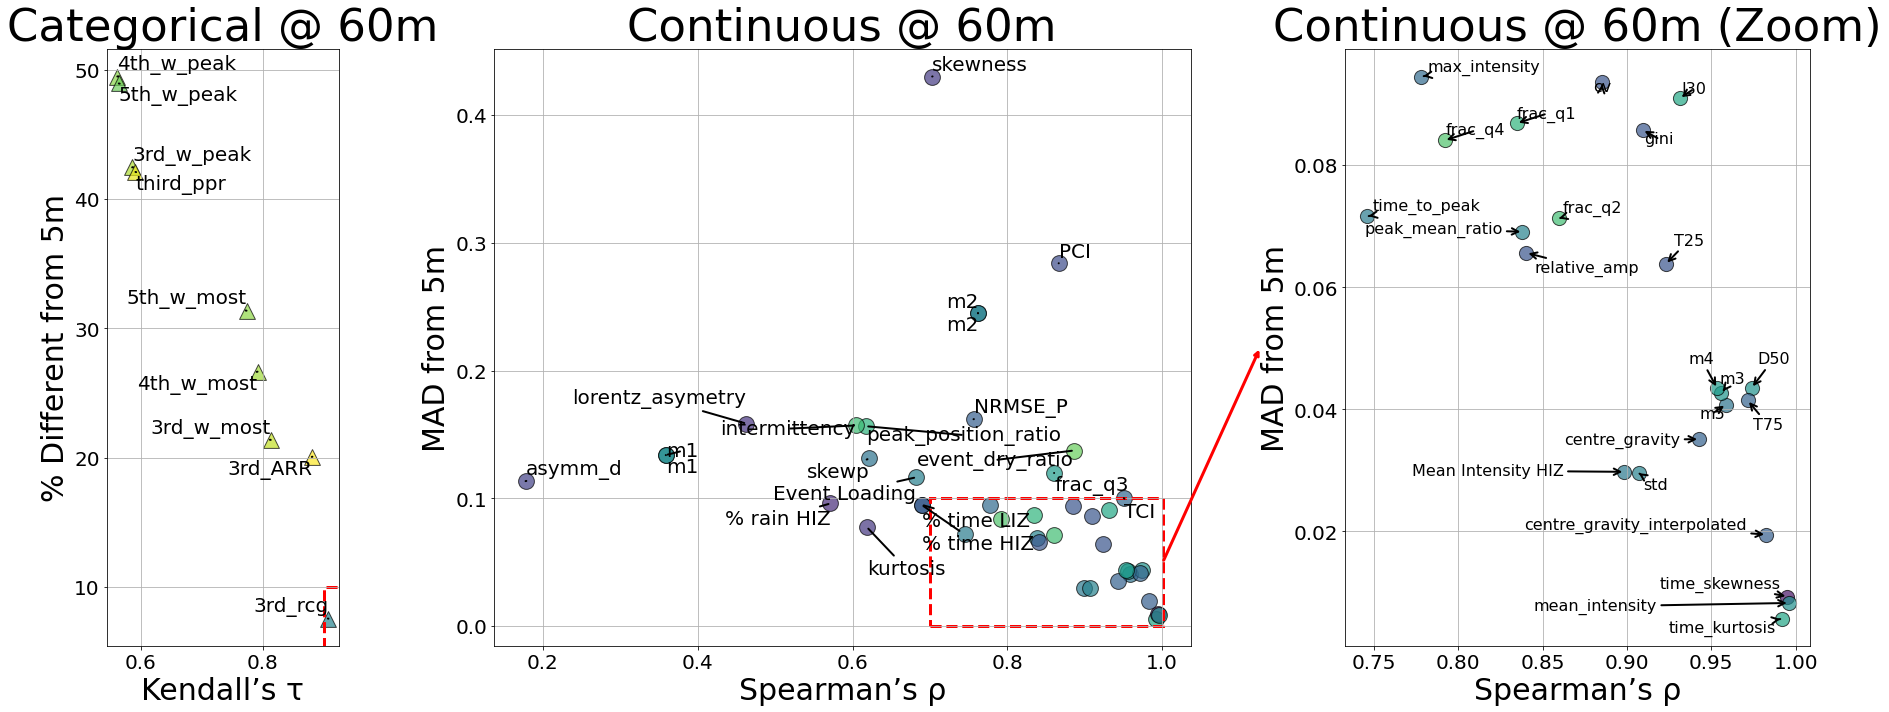

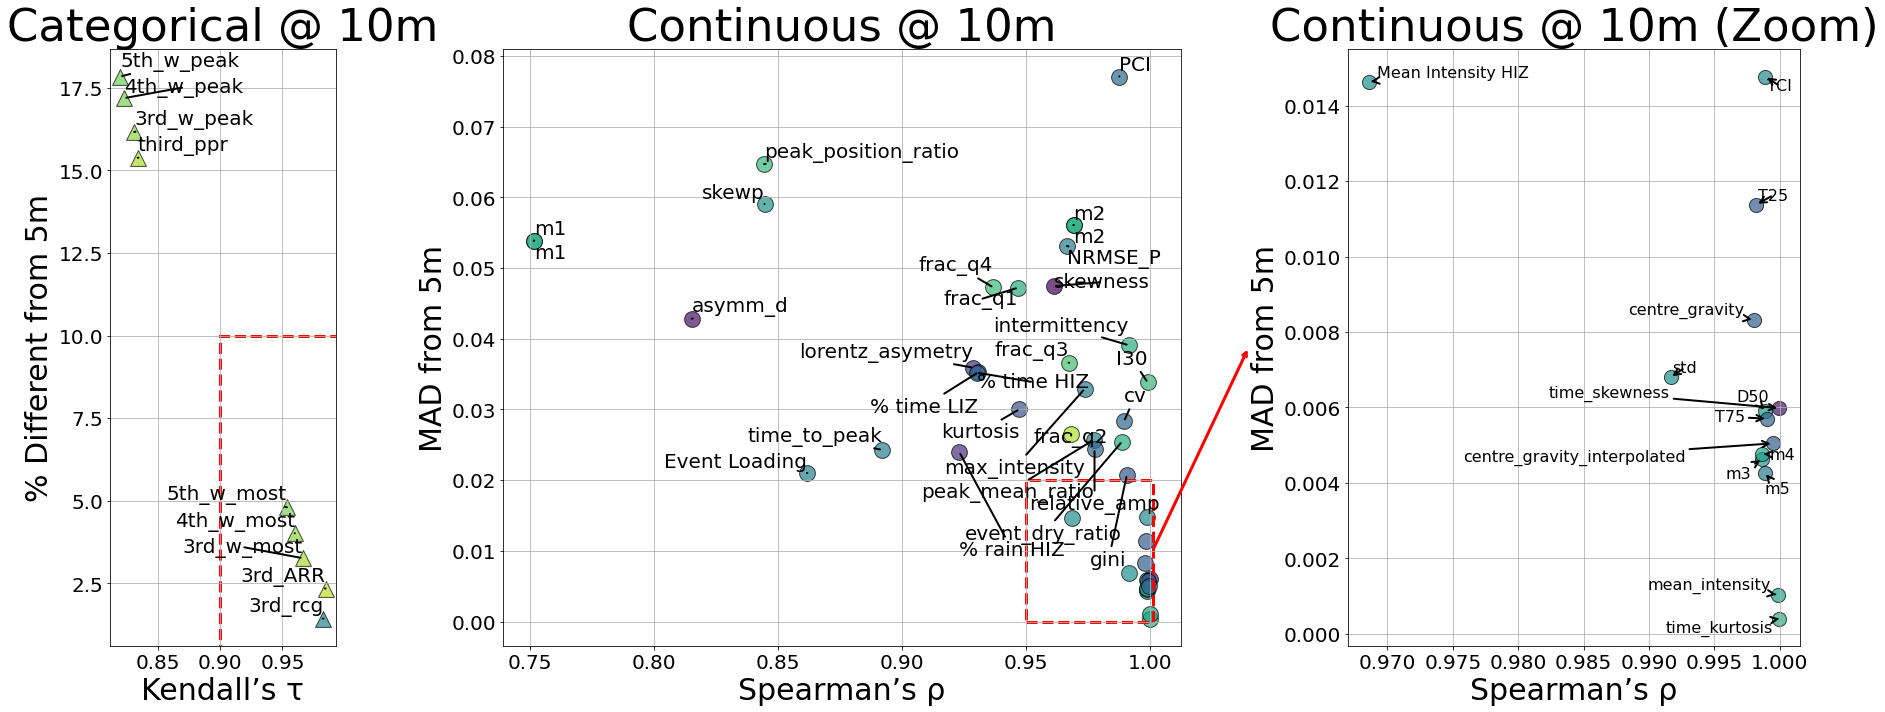

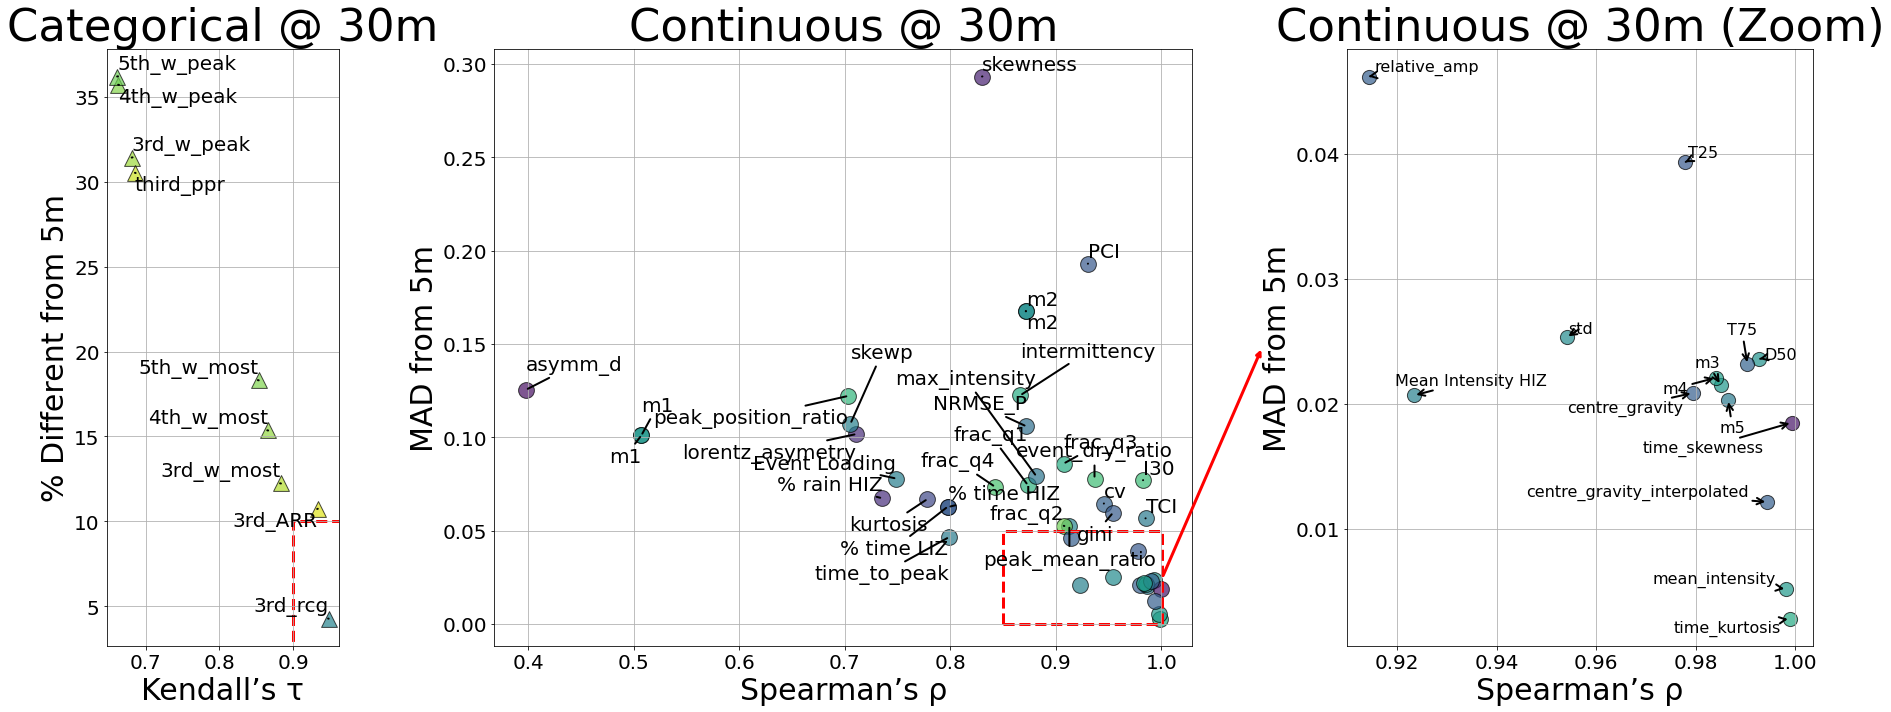

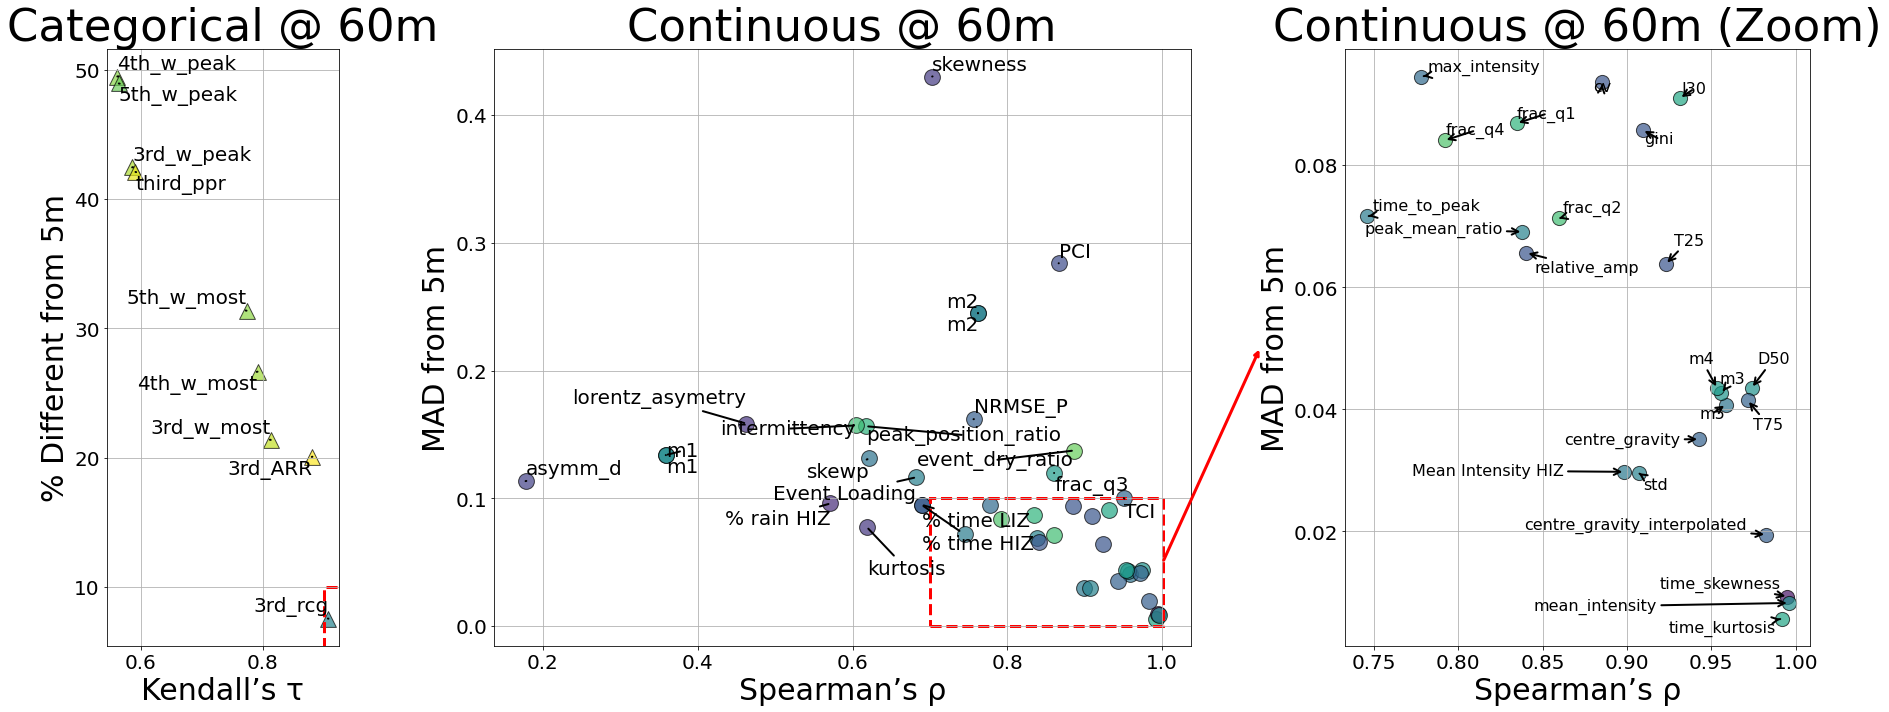

In [75]:
plot_scatter('10m')
plot_scatter('30m')
plot_scatter('60m')

,metric,resolution,type,rank_corr,val_diff,gini,type_2
55,frac_q3_wi,30m,continuous,0.907422,0.085915,0.367961,Asymmetry
58,frac_q1_wi,30m,continuous,0.873476,0.074464,0.383747,Asymmetry
59,time_kurtosis,30m,continuous,0.998921,0.002842,0.365705,Asymmetry
62,frac_q2_wi,30m,continuous,0.908099,0.052492,0.464689,Asymmetry
65,m5_wi,30m,continuous,0.986540,0.020320,0.249804,Asymmetry
66,D50,30m,continuous,0.992834,0.023599,0.311241,Asymmetry
67,m1,30m,continuous,0.507368,0.101043,0.318840,Asymmetry
68,Event Loading,30m,continuous,0.748990,0.077887,0.262821,Asymmetry
69,time_to_peak,30m,continuous,0.798795,0.046504,0.254458,Asymmetry
70,asymm_d,30m,continuous,0.398068,0.125481,0.046023,Asymmetry


In [70]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("all_scatter_plots.pdf") as pdf:
    for res in ['10m', '30m', '60m']:
        fig = plot_scatter(res)  # Return fig from your function
        pdf.savefig(fig)
        plt.close(fig)

In [232]:
# transformed_minmax_scaled[['time_to_peak_5m','peak_position_ratio_5m','skewp_5m']]

In [233]:
# transformed_minmax_scaled[['peak_mean_ratio_5m', 'ni_5m', 'm2_5m', 'relative_amp_5m']]